## Notebook to reproduce 2nd part of the lazZzy-cheetah NMA project


In [3]:
# Steinmetz data retrieval provided by NMA
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [3]:
# Data loading
import numpy as np
import glob, os

# fname = []
# path = r"U:\Data_Analysis\pak6\NMA"
# os.chdir(path)
# for file in glob.glob("*.npz"):
#     fname.append(file)
    
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


In [6]:
print(len(alldat))

39


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [7]:
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA 
import scipy.stats as spstat
from matplotlib import pyplot as plt
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
%matplotlib inline
# rcParams['axes.spines.top'] = False
# rcParams['axes.spines.right'] = False
# rcParams['figure.autolayout'] = True

In [8]:
# brain groups and regions
regions = ["vis_ctx", "thal", "hipp", "other_ctx", "midbrain", 'basal_ganglia', 'cortical_subplate']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
]

In [ ]:
# explore unit counts across regions
ls2 = []
for i in range(alldat.shape[0]):
  
  unit_in_reg = Counter(alldat[i]['brain_area']) 
  df_unit_counts = pd.DataFrame(
      [i, j] for i, j in unit_in_reg.items()
  )
  df_unit_counts.columns = ['brain_area', 'NN']
  df_unit_counts.loc[:, 'rec_idx'] = i
  ls2.append(df_unit_counts)
df_tmp = pd.concat(ls2) 

ls = []
for idx, reg in enumerate(regions):
  tmp = df_tmp[df_tmp.brain_area.isin(brain_groups[idx])]
  tmp.loc[:, 'region'] = reg
  ls.append(tmp)
df_regions = pd.concat(ls)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#   print(df_regions.groupby(['region', 'brain_area']).sum())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
rcParams['figure.figsize'] = [20, 4]

In [9]:
# create trial df
# used to select specific trials
ls = []
for idx in range(alldat.shape[0]):
  rec = alldat[idx]
  trials_n = rec['spks'].shape[1]
  trials = np.arange(trials_n)
  trial_unique = [item + '_' + str(idx) for item in trials.astype(str)]   
  df_tmp = pd.DataFrame({
      'trial':  trials,
      'feedback_time': rec['feedback_time'].flatten(),
      'feedback_type': rec['feedback_type'].flatten(),
      'gocue ': rec['gocue'].flatten(), 
      'contrast_right': rec['contrast_right'].flatten(),
      'contrast_left': rec['contrast_left'].flatten(),
      'response': rec['response'].flatten(),
      'response_time': rec['response_time'].flatten(),
      'mouse_name': rec['mouse_name'],
      'rec_idx': idx,
      'trial_unique': trial_unique,
      'reaction_time': rec['reaction_time'][:, 0], 
  })
  ls.append(df_tmp)
df_trial = pd.concat(ls)
df_trial.loc[:, 'ctr_diff'] = abs(df_trial['contrast_right'] - df_trial['contrast_left'])
df_trial.loc[:, 'ctr_avg'] = (df_trial['contrast_right'] + df_trial['contrast_left'])/2
df_trial.head()

,trial,feedback_time,feedback_type,gocue,contrast_right,contrast_left,response,response_time,mouse_name,rec_idx,trial_unique,reaction_time,ctr_diff,ctr_avg
0,0,1.186819,1.0,1.027216,0.0,1.0,1.0,1.150204,Cori,0,0_0,170.0,1.0,0.50
1,1,1.437623,1.0,0.874414,0.5,0.0,-1.0,1.399503,Cori,0,1_0,230.0,0.5,0.25
2,2,0.986016,1.0,0.825213,0.5,1.0,1.0,0.949291,Cori,0,2_0,200.0,0.5,0.75
3,3,2.296436,1.0,0.761612,0.0,0.0,0.0,2.266802,Cori,0,3_0,860.0,0.0,0.00
4,4,0.827613,-1.0,0.662010,1.0,0.5,1.0,0.816776,Cori,0,4_0,140.0,0.5,0.75


In [10]:
# define easy and hard trials
conditions = [
    (df_trial['ctr_diff'] > 0.5) |  (df_trial['ctr_avg'] == 0.25),
    (df_trial['ctr_diff'] == 0.25) | (df_trial['ctr_avg'] == 0.75),
    ]

# create a list of the values we want to assign for each condition
values = ['easy', 'hard']

# create a new column and use np.select to assign values to it using our lists as arguments
df_trial.loc[:,'trial_diff'] = np.select(conditions, values)

In [11]:
# select regions for analysis
target_regions = ['ACA', 'CA1', 'LGd', 'MRN'] + brain_groups[0]
flat_list = [item for sublist in brain_groups for item in sublist]
flat_list

### Selection of trials and sessions of interest

In [14]:
# combine data across differnt sessions
d_area = {}
# pick brain regions of interest 
for target_area in flat_list:
  sessions= []
  d_easy = {}
  d_med = {}
  for idx in range(alldat.shape[0]):
    rec = alldat[idx]
    if np.isin(target_area, np.unique(rec['brain_area'])):
      sessions.append(idx)
  
  ls_rec = []
  for idx in sessions:
    # pick correct trials
    tmp_trial = df_trial[(df_trial.rec_idx == idx) & (df_trial.feedback_type == 1)]

    easy = tmp_trial[(tmp_trial.ctr_diff > 0.5) | (tmp_trial.ctr_avg == 0.25)].trial.unique()[:30]
    med = tmp_trial[(tmp_trial.ctr_diff == 0.25)  | (tmp_trial.ctr_avg == 0.75)].trial.unique()[:30]
    # nostim_trials = tmp_trial[tmp_trial.ctr_avg == 0].trial_unique.unique()[:30]
    my_list1 = [easy.shape[0], med.shape[0]]
    # print ([easy.shape[0], med.shape[0]])
    # select recs with at least 30 easy and hard trials
    if all(i >= 30 for i in my_list1):
      d_easy[idx] = easy
      d_med[idx] = med
      ls_rec.append(idx)
  print (target_area, len(ls_rec))
  # include region only if there are >3 rec sessions 
  if len(ls_rec) < 3:
    continue
  ls = []
  # load spikes data and concat trials
  for idx in ls_rec:
    rec = alldat[idx]
    if np.isin(target_area, np.unique(rec['brain_area'])):
      idx_units = np.where(rec['brain_area'] == target_area)[0]
      spks = rec['spks'][idx_units]
      # first 30 = easy, 2nd 30 medium 
      trials_trgt = np.concatenate([d_easy[idx], d_med[idx]])
      spks_trgt = spks[:, trials_trgt,]
      ls.append(spks_trgt)
  _spk_inp = np.concatenate(ls, axis = 0) 
  d_area[target_area] = _spk_inp
print(d_area.keys())

VISa 2
VISam 6
VISl 2
VISp 6
VISpm 0
VISrl 1
CL 0
LD 3
LGd 7
LH 2
LP 2
MD 2
MG 0
PO 0
POL 1
PT 1
RT 1
SPF 0
TH 6
VAL 0
VPL 4
VPM 2
CA 1
CA1 10
CA2 0
CA3 5
DG 7
SUB 4
POST 1
ACA 7
AUD 1
COA 0
DP 0
ILA 1
MOp 1
MOs 10
OLF 2
ORB 3
ORBm 1
PIR 1
PL 7
SSp 3
SSs 1
RSP 4
 TT 0
APN 0
IC 1
MB 4
MRN 6
NB 0
PAG 2
RN 1
SCs 3
SCm 5
SCig 0
SCsg 3
ZI 3
ACB 2
CP 3
GPe 2
LS 1
LSc 1
LSr 3
MS 1
OT 1
SNr 1
SI 1
BLA 1
BMA 0
EP 0
EPd 1
MEA 1
dict_keys(['VISam', 'VISp', 'LD', 'LGd', 'TH', 'VPL', 'CA1', 'CA3', 'DG', 'SUB', 'ACA', 'MOs', 'ORB', 'PL', 'SSp', 'RSP', 'MB', 'MRN', 'SCs', 'SCm', 'SCsg', 'ZI', 'CP', 'LSr'])


### PCA

In [15]:
# perform PCA on trial averaged data
d_pc = {}
d_var = {}
flag_avg = True
for i in d_area.keys():
    n_comp = 20
    _spk_inp = d_area[i]
    # number of units
    n_units = _spk_inp.shape[0]
    # number of time points/bins
    n_bins = _spk_inp.shape[2]
    # number of trials
    n_trials = _spk_inp.shape[1]
    if flag_avg == True:

        # trial average pc
        # average across easy/hard trials
        a = _spk_inp[:,:30,50:150].mean(axis = 1)
        b = _spk_inp[:,30:,50:150].mean(axis = 1)
        droll = np.concatenate([a, b], axis = 1)
        # fit PCA
        model = PCA(n_components = n_comp).fit(droll.T)
        W = model.components_
        # project original single trial data to PCA space
        pc = W @ _spk_inp.reshape((n_units, -1))
        # reshape to units, trials, times
        pc = np.reshape(pc, (n_comp, -1, n_bins))
        # variance explained by each PC
        var_expl = np.round(100 * model.explained_variance_ratio_,1)
        d_pc[i] = pc
        d_var[i] = var_expl
        
    else:
        
        droll = np.reshape(_spk_inp[:,:,51:150], (n_units,-1))
        droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
        model = PCA(n_components = n_comp).fit(droll.T)
        W = model.components_
        pc = W @ _spk_inp.reshape((n_units, -1))
        pc = np.reshape(pc, (n_comp, -1, n_bins))
        var_expl = np.round(100 * model.explained_variance_ratio_,1)
        d_pc[i] = pc
        d_var[i] = var_expl

(80, 60, 250)

In [379]:
pc.shape

(80, 60, 250)

### Plotting of neural responses and PCs 

Text(50.0, 0.5, '# of Units: 592')

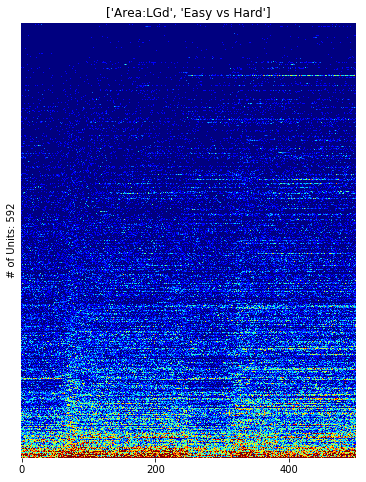

In [16]:
# plot original data: each row is aunit activity across time; left = easy, right hard trials
dt = 0.01
fig = plt.figure(figsize = (6, 8))
target_area = 'LGd'
_spk_inp = d_area[target_area]
plt.title(['Area:%s'%target_area, 'Easy vs Hard'])

tmp = _spk_inp[:,:30, ].mean(axis = 1)
tmp2 = _spk_inp[:,30:, ].mean(axis = 1)
hm = np.hstack([tmp, tmp2])
hm2 = hm[ np.argsort(np.mean(hm[:,50:100], axis = 1) )]
g = sns.heatmap(hm2*1/dt, cmap = 'jet', vmin = 0, vmax = 30, xticklabels = 200, yticklabels = '', cbar = False)
g.set_ylabel('# of Units: %i'%_spk_inp.shape[0])
# plt.savefig('hm_%s'%target_area  + '.png')

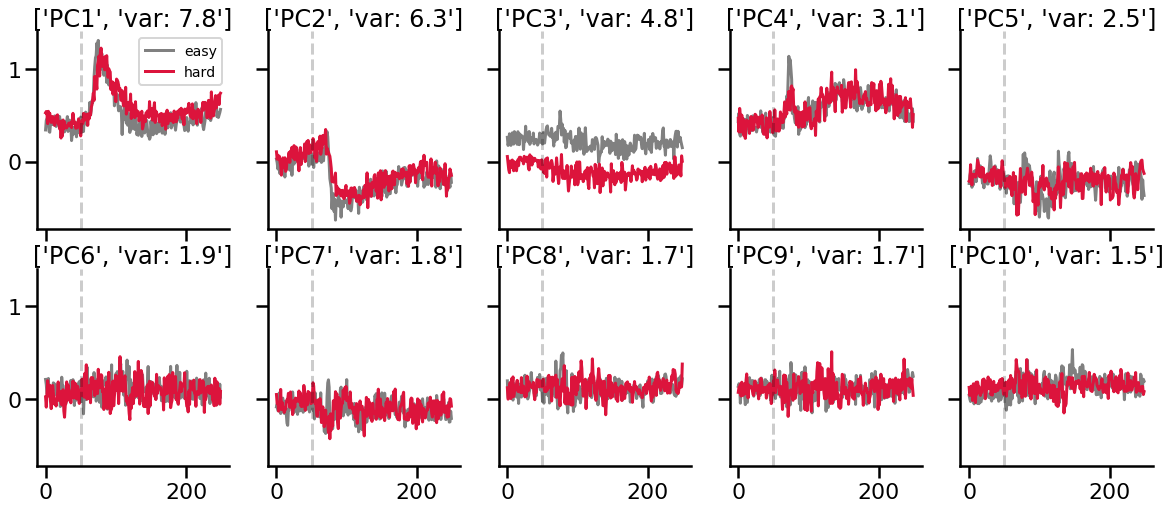

In [19]:
sns.set_context('poster')

# plot top PC projections
pc = d_pc[target_area]
var_expl = d_var[target_area]
f, ax = plt.subplots(2, 5, figsize = (20, 8), sharex = True, sharey = True)
axs = ax.ravel()
for i in range(10):

  axs[i].title.set_text(['PC%s'%(i+1), 'var: %s'%var_expl[i]])
  axs[i].plot(pc[i, :30].mean(axis = 0), c = 'gray')
  axs[i].plot(pc[i, 30:].mean(axis = 0), c = 'crimson')
  axs[i].axvline (x = 50, linestyle = '--', c = 'k', alpha = 0.2)
  if i==0:
    axs[i].legend(['easy', 'hard'], loc = 'best', fontsize=14)
# plt.savefig('top_pc_avg%s'%target_area + '.svg')
sns.despine()

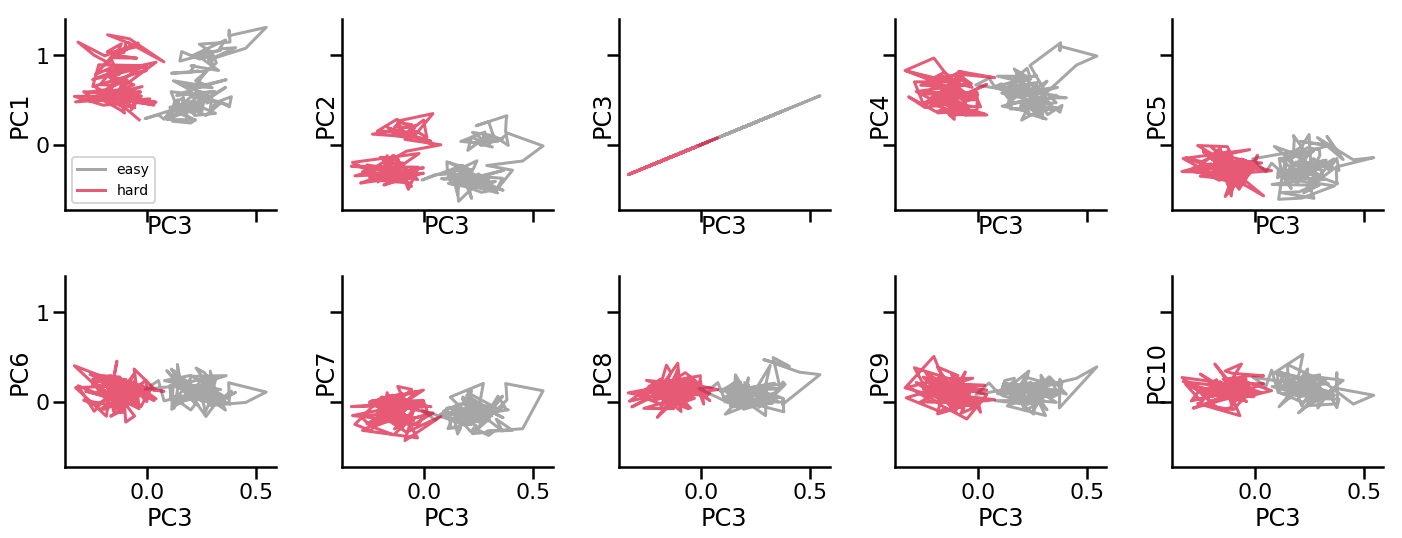

In [21]:
# rcParams['figure.figsize'] = [20, 8]
# plot state space plots PCs vs other PCs
f, ax = plt.subplots(2, 5, figsize = (20, 8), sharex = True, sharey = True, facecolor = 'white')
axs = ax.ravel()
pc_x = 2
for i in range(10):

  pc_x_easy = pc[pc_x, :30].mean(axis = 0)[50:150]
  pc_y_easy = pc[i, :30].mean(axis = 0)[50:150]
  pc_x_med = pc[pc_x, 30:].mean(axis = 0)[50:150]
  pc_y_med = pc[i, 30:].mean(axis = 0)[50:150]

  axs[i].plot(pc_x_easy, pc_y_easy, alpha = 0.7, c = 'gray')
  axs[i].plot(pc_x_med, pc_y_med, alpha = 0.7, c = 'crimson')

  axs[i].set_xlabel('PC%s'%str(pc_x+1))
  axs[i].set_ylabel('PC%s'%str(i+1))

  if i==0:
    axs[i].legend(['easy', 'hard'], loc = 'best', fontsize=14)
plt.tight_layout()
sns.despine()
# plt.savefig('top_pc_state_space%s'%target_area + '.svg')

### Perform PCA on units from different brain regions

In [29]:
# PCA on units from seevral regions
ls = []
for i in d_area.keys():
    print (i, d_area[i].shape)
    ls.append(d_area[i])
# aggregate data from differnt sessions
all_mat = np.concatenate(ls)
n_units = all_mat.shape[0] 
_spk_inp = all_mat
a = _spk_inp[:,:30,51:150].mean(axis = 1)
b = _spk_inp[:,30:,51:150].mean(axis = 1)
_spk_inp = np.concatenate([a, b], axis = 1)
droll = _spk_inp
model = PCA(n_components = n_comp).fit(droll.T)
W = model.components_
pc = W @ all_mat.reshape((n_units, -1))
pc = np.reshape(pc, (n_comp, 60, -1))
var_expl = np.round(100 * model.explained_variance_ratio_,1)

VISam (405, 60, 250)
VISp (400, 60, 250)
LD (133, 60, 250)
LGd (592, 60, 250)
TH (957, 60, 250)
VPL (301, 60, 250)
CA1 (582, 60, 250)
CA3 (275, 60, 250)
DG (412, 60, 250)
SUB (407, 60, 250)
ACA (620, 60, 250)
MOs (622, 60, 250)
ORB (355, 60, 250)
PL (646, 60, 250)
SSp (74, 60, 250)
RSP (318, 60, 250)
MB (460, 60, 250)
MRN (429, 60, 250)
SCs (142, 60, 250)
SCm (228, 60, 250)
SCsg (46, 60, 250)
ZI (245, 60, 250)
CP (492, 60, 250)
LSr (472, 60, 250)


Text(0.5, 103.9999999999999, 'Top 5 PC')

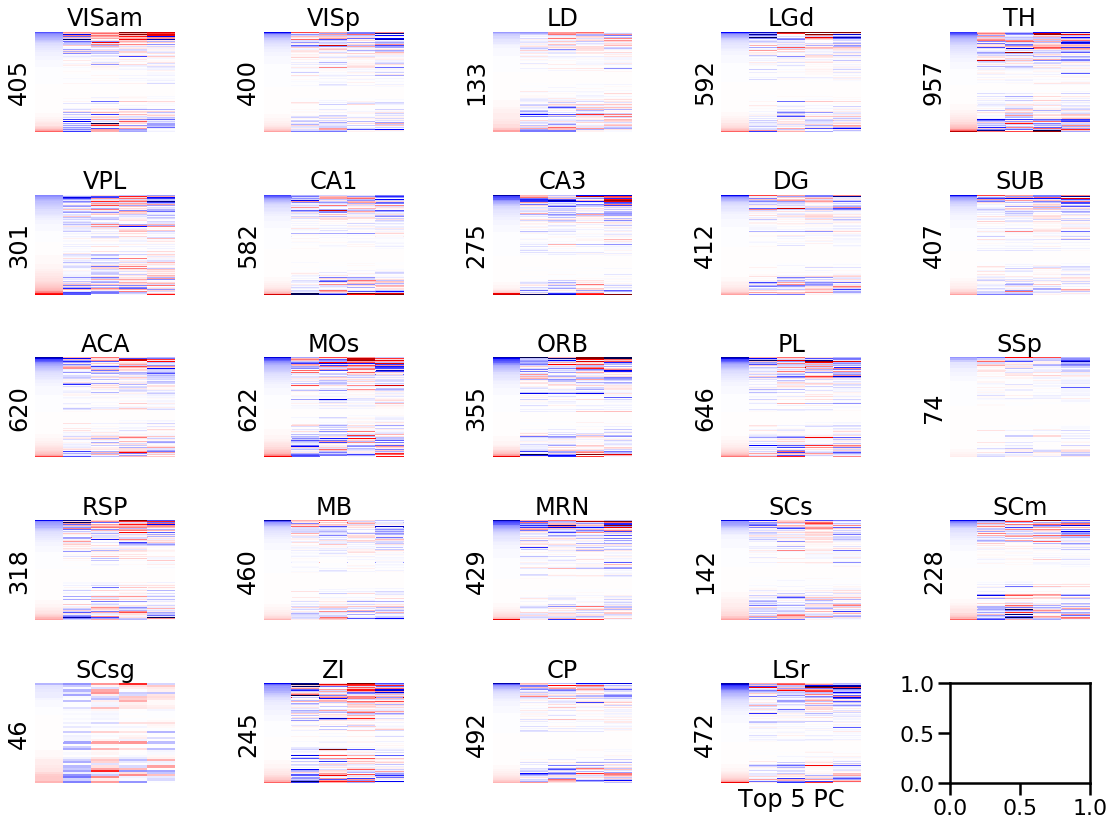

In [37]:
# visua;ize weights of W matrix
f, ax = plt.subplots(5, 5, figsize = (16,12))
axs = ax.ravel()
# cbar_ax = f.add_axes([1, .3, .03, .4])
start = 0
for i,v in enumerate(d_area.keys()):
    n_units = d_area[v].shape[0]
    axs[i].title.set_text('%s'%(v))
    hm = W.T[start:n_units+start,:5]
    hm2 = hm[ np.argsort(np.mean(hm[:,:1], axis = 1) )]
    sns.heatmap(hm2, xticklabels = '', yticklabels = '', 
                cbar=i == 25, cmap = 'seismic',  ax = axs[i], vmin = -0.05, vmax = 0.05,
#                  cbar_ax=None if i else cbar_ax
               )
    start = n_units
    axs[i].set_ylabel(n_units)
plt.tight_layout()
axs[i].set_xlabel('Top 5 PC')

In [38]:
W.shape

(20, 9613)

### Decoding task difficulty from different regions

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, train_test_split, RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, LeaveOneOut

In [25]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
# lr = LogisticRegression(C = 1e-2,
#                         penalty='l2',
#                         # fit_intercept=True,
#                         max_iter=10000,
#                         random_state=42,
#                         )
# kf = KFold(n_splits = 4)
loo = LeaveOneOut()
ls_cond = []
y = np.zeros(60)
y[30:] = 1
n_pc = 5
rskf = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 5,
    random_state = 3)
time_w = [(50, 200), (50, 100), (100, 150), (150, 200)]

for k in d_pc.keys():
#     if 'VIS' in k:
#         continue
    var_exp = d_var[k][:n_pc].sum()
    pc = d_pc[k]
    for w in time_w:
        x_ = pc[:n_pc, :, w[0]:w[1]].sum(axis = 2).T
#         np.random.shuffle(y)
        y_ = y
        scores = cross_val_score(lda, x_, y_, cv = loo)
        print (scores.mean())
        tmp_df = pd.DataFrame({'area': k, 'window': str(w[0]) + '-' + str(w[1]), 
                               'var_exp': var_exp, 'acc': scores})
        ls_cond.append(tmp_df)
        
df_lg = pd.concat(ls_cond)

0.6833333333333333
0.7166666666666667
0.7
0.6666666666666666
0.8166666666666667
0.85
0.7833333333333333
0.7333333333333333
0.75
0.7833333333333333
0.8
0.6
0.9
0.9333333333333333
0.9333333333333333
0.85
0.7666666666666667
0.7833333333333333
0.7666666666666667
0.75
0.8166666666666667
0.8166666666666667
0.8166666666666667
0.7166666666666667
0.75
0.7666666666666667
0.75
0.75
0.8833333333333333
0.7333333333333333
0.7833333333333333
0.7833333333333333
0.8
0.7833333333333333
0.8
0.7333333333333333
0.7666666666666667
0.8166666666666667
0.7666666666666667
0.6833333333333333
0.7666666666666667
0.8
0.8166666666666667
0.6833333333333333
0.7166666666666667
0.7166666666666667
0.7333333333333333
0.6833333333333333
0.6833333333333333
0.6833333333333333
0.65
0.6166666666666667
0.75
0.8166666666666667
0.75
0.6833333333333333
0.45
0.45
0.55
0.45
0.7666666666666667
0.7833333333333333
0.7333333333333333
0.75
0.7833333333333333
0.8166666666666667
0.7833333333333333
0.7166666666666667
0.75
0.75
0.78333333333

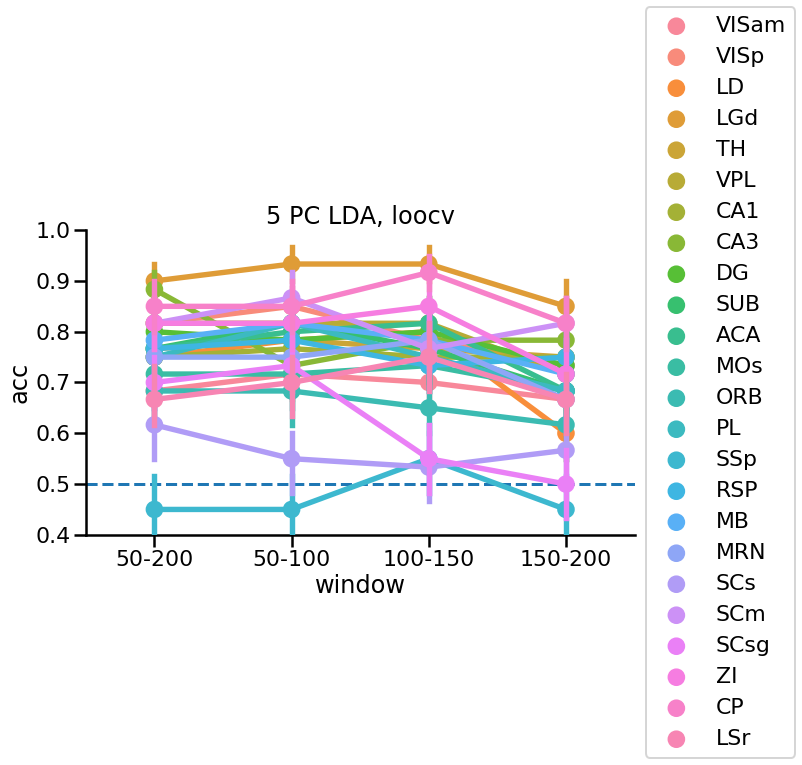

In [26]:

g = sns.catplot(data = df_lg, x = 'window', y = 'acc',
                ci = 68, kind = 'point', hue = 'area', legend = False, height = 6, aspect = 1.6)
plt.axhline(y = 0.5, linestyle = '--')
plt.ylim(0.4, 1)
plt.title('%i PC LDA, loocv'%n_pc)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

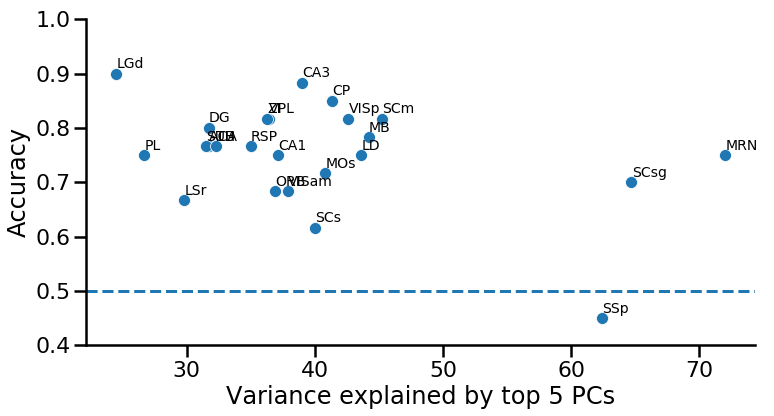

In [41]:
# plot scatter plot of variance explained by top 5 PC vs decoding accuracy 
f, ax = plt.subplots(figsize = (12, 6))
tmp = df_lg[df_lg.window == '50-200'].groupby('area').mean().reset_index()
g = sns.scatterplot(x = tmp.var_exp, y = tmp.acc)
g.set_xlabel('Variance explained by top 5 PCs')
g.set_ylabel('Accuracy')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.02, point['y']+0.01, str(point['val']), fontsize = 14)

label_point(tmp.var_exp, tmp.acc, tmp.area, plt.gca()) 
plt.ylim(0.4, 1)
plt.axhline(y = 0.5, linestyle = '--')
sns.despine()
# plt.savefig('scatter_pc_var_dec.svg')

In [ ]:
df_lp.unit.unique().size

400